In [18]:
jupyter nbextension enable cellfolding --user --py

SyntaxError: invalid syntax (3069101423.py, line 1)

In [31]:
import networkx as nx
G=nx.Graph()
for i in range(1,16):
    G.add_node(i)

G.add_edge(1,2)
G.add_edge(2,5)
G.add_edge(5,12)
G.add_edge(1,3)
G.add_edge(3,6)
G.add_edge(6,11)
G.add_edge(11,12)
G.add_edge(2,3)
G.add_edge(2,11)
G.add_edge(1,4)
G.add_edge(3,4)
G.add_edge(3,7)
G.add_edge(6,7)
G.add_edge(6,10)
G.add_edge(11,10)
G.add_edge(7,10)
G.add_edge(11,13)
G.add_edge(10,13)
G.add_edge(12,13)
G.add_edge(4,9)
G.add_edge(7,9)
G.add_edge(10,9)
G.add_edge(15,9)
G.add_edge(8,9)
G.add_edge(4,8)
G.add_edge(15,14)
G.add_edge(10,14)
G.add_edge(13,14)
for edge in G.edges():
    G[edge[0]][edge[1]]['capacity']=12*100
G[2][3]['capacity']=48*100
G[2][5]['capacity']=48*100
G[14][15]['capacity']=48*100
G[3][6]['capacity']=48*100
G[6][11]['capacity']=48*100
G[3][7]['capacity']=48*100
G[6][10]['capacity']=48*100
G[11][10]['capacity']=48*100
G[7][10]['capacity']=48*100
IEP=[[1,13],[5,9],[4,2],[5,15],[13,2]]

In [32]:
# import random
# DEMAND=[]
# PAIR=[]
# for d in range(4000):
#     DEMAND.append(random.randint(1,4))
#     PAIR.append(random.randint(0,4))

import csv
with open(r"C:\Users\HARIHARAN SUBRAMANIA\Desktop\ACTUAL CN PROJ\demands.csv","r") as csv:
    f=csv.read()
f=f[26:].split("\n")
for i in range(len(f)):
    f[i]=f[i].split(",")
DEMAND=[]
PAIR=[]
for i in range(4000):
    DEMAND.append(int(f[i][2]))
    pair=tuple((int(f[i][0]),int(f[i][1])))
    for k in range(len(IEP)):
        if tuple(IEP[k])==pair:
            PAIR.append(k)
    


##### MIRA

In [33]:
def subtracted_graph(G,flow_dict):
    for k in flow_dict.keys():
        for j in flow_dict[k].keys():
            if flow_dict[k][j]>0:
                G[k][j]['capacity']-=flow_dict[k][j]
    return G.copy()
def critical_checker(G,s,d):
    critical_links=[]
    new_graph=G.copy()
    for edge in G.edges():
        if new_graph[edge[0]][edge[1]]['capacity']==0:
            new_graph.remove_edge(edge[0],edge[1])
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']==0 and edge[1] not in nx.descendants(new_graph,s) and edge[0] not in nx.descendants(new_graph,d) and nx.has_path(new_graph, edge[0],edge[1])==False:
            critical_links.append(edge)
    return critical_links
def critical_value_checker(G,IEP_without_ab,flow_dict_all):
    critical_links={}
    critical_links_overall={}

    for sd in IEP_without_ab:
        critical_links_overall[tuple((sd[0],sd[1]))]=[]
        critical_links={}
        for edge in G.edges():
            critical_links[tuple((edge[0],edge[1]))]=0
        flow_dict=flow_dict_all[tuple((sd[0],sd[1]))].copy()
        for k in flow_dict.keys():
            for j in flow_dict[k].keys():
                if flow_dict[k][j]>0:
                    try:
                        critical_links[tuple((k,j))]+=flow_dict[k][j]
                    except:
                        critical_links[tuple((j,k))]+=flow_dict[k][j]
        critical_links_overall[tuple((sd[0],sd[1]))]=critical_links.copy()
    return critical_links_overall
def non_vital_flow_contributor(G,IEP_without_ab,flow_dict_all):
    critical_links={}
    for edge in G.edges():
        critical_links[tuple((edge[0],edge[1]))]=0

    for sd in IEP_without_ab:
        flow_dict=flow_dict_all[tuple((sd[0],sd[1]))].copy()
        for k in flow_dict.keys():
            for j in flow_dict[k].keys():
                if flow_dict[k][j]>0:
                    try:
                        critical_links[tuple((k,j))]+=flow_dict[k][j]
                    except:
                        critical_links[tuple((j,k))]+=flow_dict[k][j]
    return critical_links
def MIRA(G,ab,IEP,D):
    from networkx.algorithms.flow import preflow_push
    #1. Compute Maximum flow values for all (s,d) in P excluding (a,b)
    max_flow_calc={}
    IEP_without_ab=IEP.copy()
    IEP_without_ab.remove(ab)
    aaaa=[]
    max_flow_dict={}
    for sd in IEP_without_ab:
        #print(nx.maximum_flow(G,sd[0],sd[1])[0])
        max_flow_calc[tuple(sd)]=nx.maximum_flow(G,sd[0],sd[1])[0]
        max_flow_dict[tuple(sd)]=nx.maximum_flow(G,sd[0],sd[1])[1]
    #2. Compute Critical links C_sd
    critical_links={}
    for sd in IEP_without_ab:
        
        critical_links[tuple(sd)]=[]
        subt_graph=nx.Graph()
        subt_graph=subtracted_graph(G.copy(),max_flow_dict[tuple(sd)])
        critical_links[tuple(sd)]=critical_checker(subt_graph.copy(),sd[0],sd[1])
    flow_contributor=critical_value_checker(G.copy(),IEP_without_ab,max_flow_dict)
    inverse_max_flow_calc={}

    for sd in IEP_without_ab:
        if max_flow_calc[tuple(sd)]==0:
            max_flow_calc[tuple(sd)]=0.000000000001
        inverse_max_flow_calc[tuple(sd)]=1/max_flow_calc[tuple(sd)]
    #3 Compute the weight of links w(l)
    w={}
    curr_sum=0
    c_length=[]
    for c in critical_links.keys():
        c_length.append(len(critical_links[c]))
    for edge in G.edges:
        curr_sum=0
        for keys,values in critical_links.items():
            if edge in critical_links[keys]:
                curr_sum+=inverse_max_flow_calc[keys]#(1/flow_contributor[keys][edge])
        w[edge]=curr_sum
    non_vital_edge_flow_contributor=non_vital_flow_contributor(G.copy(), IEP_without_ab,max_flow_dict)
    import random as random
    #print(w)
    for keys,values in w.items():
        if w[keys]==0:
            if non_vital_edge_flow_contributor[keys]!=0:
                w[keys]=1/(non_vital_edge_flow_contributor[keys]*1000)
            else:
                w[keys]=0
    #Later on whoseover w(l)=0, choose the minimum no of hops
    #4.Eliminate <D edges and form reduced network
    new_G=nx.Graph()
    for node in G.nodes():
        new_G.add_node(node)
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']-D>=0:
            new_G.add_edge(edge[0],edge[1])
            new_G[edge[0]][edge[1]]['capacity']=w[edge]/G[edge[0]][edge[1]]['capacity']
    try:
        shortest_path=nx.shortest_path(new_G,ab[0],ab[1],weight='capacity')
    except:
        print("No Path Found from",ab[0],"to",ab[1])
        return G.copy(),0,0
    for i in range(len(shortest_path)-1):
        G[shortest_path[i]][shortest_path[i+1]]['capacity']-=D
    format_modified_shortest_path=[]
    for i in range(len(shortest_path)-1):
        l=[shortest_path[i],shortest_path[i+1]]
        format_modified_shortest_path.append(l)

    return G.copy(),aaaa,format_modified_shortest_path
        

##### MHA


In [34]:
def MHA(G,ab,D):
    G_temp=G.copy()
    G_temp_edge_list=list(G_temp.edges())
    for edge in G_temp_edge_list:
        if G_temp.get_edge_data(edge[0],edge[1])['capacity']<D:
            G_temp.remove_edge(edge[0],edge[1])
    for edge in G_temp.edges():
        G_temp[edge[0]][edge[1]]['capacity']=1
    try:
        shortest_path=nx.shortest_path(G_temp,ab[0],ab[1],weight='capacity')
    except:
        print("No Path Found from",ab[0],"to",ab[1])
        return G.copy(),0
    for i in range(len(shortest_path)-1):
        G[shortest_path[i]][shortest_path[i+1]]['capacity']-=D
    format_modified_shortest_path=[]
    for i in range(len(shortest_path)-1):
        l=[shortest_path[i],shortest_path[i+1]]
        format_modified_shortest_path.append(l)
#     for edge in G.edges():
#         print(G.get_edge_data(edge[0],edge[1])['capacity'])
    return G.copy(),format_modified_shortest_path


##### IMIRA

In [35]:

def how_many_paths(G,sd,ij):
    all_paths=list(nx.all_simple_paths(G,sd[0],sd[1]))
    usage=0
    for path in all_paths:
        for i in range(len(path)-1):
            if (path[i]==ij[0] and path[i+1]==ij[1]) or (path[i]==ij[1] and path[i+1]==ij[0]):
                usage+=1
    return usage/len(all_paths)

def MIRA_1(G,ab,IEP,D):
    from networkx.algorithms.flow import preflow_push
    #1. Compute Maximum flow values for all (s,d) in P excluding (a,b)
    max_flow_calc={}
    IEP_without_ab=IEP.copy()
    IEP_without_ab.remove(ab)
    aaaa=[]
    max_flow_dict={}
    for sd in IEP_without_ab:
        #print(nx.maximum_flow(G,sd[0],sd[1])[0])
        max_flow_calc[tuple(sd)]=nx.maximum_flow(G,sd[0],sd[1])[0]
        max_flow_dict[tuple(sd)]=nx.maximum_flow(G,sd[0],sd[1])[1]
    #2. Compute Critical links C_sd
    link_weight={}
    for edge in G.edges():
        link_weight[edge]=0
    for edge in G.edges():
        for sd in IEP_without_ab:
            maxflow_ratio=max_flow_dict[tuple(sd)][edge[0]][edge[1]]/((max_flow_calc[tuple(sd)]*G[edge[0]][edge[1]]['capacity'])+0.00000000000000000000001)
            link_weight[edge]+=maxflow_ratio
    new_G=nx.Graph()
    for node in G.nodes():
        new_G.add_node(node)
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']-D>=0:
            new_G.add_edge(edge[0],edge[1])
            new_G[edge[0]][edge[1]]['capacity']=link_weight[edge]
    try:
        shortest_path=nx.shortest_path(new_G,ab[0],ab[1],weight='capacity')
    except:
        print("No Path Found from",ab[0],"to",ab[1])
        return G.copy(),0,0
    
    for i in range(len(shortest_path)-1):
        G[shortest_path[i]][shortest_path[i+1]]['capacity']-=D
    format_modified_shortest_path=[]
    for i in range(len(shortest_path)-1):
        l=[shortest_path[i],shortest_path[i+1]]
        format_modified_shortest_path.append(l)
#     for edge in G.edges():
#         print(G.get_edge_data(edge[0],edge[1])['capacity'])
    return G.copy(),aaaa,format_modified_shortest_path
        

##### MIH

In [36]:
def MIH(G,ab,IEP,D,fij,entire_cap,T1=8,T2=4):
    from networkx.algorithms.flow import preflow_push
    #1. Compute Maximum flow values for all (s,d) in P excluding (a,b)
    max_flow_calc={}
    max_flow_dict={}
    IEP_without_ab=IEP.copy()
    IEP_without_ab.remove(ab)
    aaaa=[]
    for sd in IEP_without_ab:
        #print(nx.maximum_flow(G,sd[0],sd[1])[0])
        max_flow_calc[tuple(sd)]=nx.maximum_flow(G,sd[0],sd[1])[0]
        max_flow_dict[tuple(sd)]=nx.maximum_flow(G,sd[0],sd[1])[1]
    #2. Compute Critical links C_sd
    critical_links={}
#     for sd in IEP_without_ab:
#         critical_links[tuple(sd)]=[]
#         current_max_flow_graph=preflow_push(G,sd[0],sd[1])
#         new_graph=nx.Graph()
#         for n_node in current_max_flow_graph.nodes:
#             new_graph.add_node(n_node)
#         for n_edge in current_max_flow_graph.edges:
#             #print(current_max_flow_graph[n_edge[0]][n_edge[1]]['flow'])
#             if current_max_flow_graph[n_edge[0]][n_edge[1]]['flow']>0 or current_max_flow_graph[n_edge[1]][n_edge[0]]['flow']>0:
#                 new_graph.add_edge(n_edge[0],n_edge[1])
#         for edge in G.edges:
#             if current_max_flow_graph[edge[0]][edge[1]]['flow']<=0 and nx.has_path(new_graph,edge[0],edge[1])==False and edge[0] not in nx.descendants(new_graph,sd[1]) and edge[1] not in nx.descendants(new_graph,sd[0]):
#                 critical_links[tuple(sd)].append(edge)
#         aaaa.append(new_graph)
    for sd in IEP_without_ab:
        
        critical_links[tuple(sd)]=[]
        subt_graph=nx.Graph()
        subt_graph=subtracted_graph(G.copy(),max_flow_dict[tuple(sd)])
        critical_links[tuple(sd)]=critical_checker(subt_graph.copy(),sd[0],sd[1])
    inverse_max_flow_calc={}
    for sd in IEP_without_ab:
        inverse_max_flow_calc[tuple(sd)]=1/(0.00000000000001+max_flow_calc[tuple(sd)])
    #3 Compute Criticality of each link g(ij)
    criticality={}
    for edge in G.edges():
        criticality[edge]=0
    for c in critical_links.keys():
        for edge in critical_links[c]:
            criticality[edge]=criticality.get(edge,0)+1
    #4 Compute max link criticality
    beta=-1
    for k in criticality.keys():
        if criticality[k]>beta:
            beta=criticality[k]
    #5 Compute link utilization fij
    link_utilization={}
    for edge in G.edges():
        link_utilization[edge]=fij[edge]/entire_cap[edge]          #D/G[edge[0]][edge[1]]['capacity']
    #6 Max link utilization alpha
    alpha=-1
    for k in link_utilization.keys():
        if link_utilization[k]>alpha:
            alpha=link_utilization[k]
    
    
    
    #7 Compute the weight of links w(l)
    w={}
    for edge in G.edges():
        w[edge]=((fij[edge]+D)/entire_cap[edge])+T1*max(0,((fij[edge]+D)/entire_cap[edge])-alpha)+T2*(criticality[edge]/beta)
        
    
    #8.Eliminate <D edges and form reduced network 
    new_G=nx.Graph()
    for node in G.nodes():
        new_G.add_node(node)
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']-D>0:
            new_G.add_edge(edge[0],edge[1])
            new_G[edge[0]][edge[1]]['capacity']=w[edge]
    #9 Use Djikstra algo for shortest path
    try:
        shortest_path=nx.shortest_path(new_G,ab[0],ab[1],weight='capacity')
    except:
        #print("No Path Found from",ab[0],"to",ab[1])
        return G.copy(),0,0
    for i in range(len(shortest_path)-1):
        G[shortest_path[i]][shortest_path[i+1]]['capacity']-=D
        try:
            fij[tuple((shortest_path[i],shortest_path[i+1]))]+=D
        except:
            fij[tuple((shortest_path[i+1],shortest_path[i]))]+=D
    format_modified_shortest_path=[]
    for i in range(len(shortest_path)-1):
        l=[shortest_path[i],shortest_path[i+1]]
        format_modified_shortest_path.append(l)
#     for edge in G.edges():
#         print(G.get_edge_data(edge[0],edge[1])['capacity'])
    return G.copy(),aaaa,format_modified_shortest_path


##### LIOA

In [37]:
def LIOA(G, ab, IEP,D,capacity_dict,demand_dict,alpha):
    aaaa=[]
    
    # 1. Set weight of all links
    w={}
    for edge in G.edges():
        w[edge]=0
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']!=0:
            w[edge]=((demand_dict[edge])**alpha)/((G[edge[0]][edge[1]]['capacity'])**(1-alpha))
        else:
            w[edge]=((demand_dict[edge])**alpha)/0.00000000000001
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']<= D:
            w[edge]=10**30
            
    #2.Eliminate <D edges and form reduced network
    new_G=nx.Graph()
    for node in G.nodes():
        new_G.add_node(node)
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']-D>=0:
            new_G.add_edge(edge[0],edge[1])
            new_G[edge[0]][edge[1]]['capacity']=w[edge]
    try:
        shortest_path=nx.shortest_path(new_G,ab[0],ab[1],weight='capacity')
    except:
        #print("No Path Found from",ab[0],"to",ab[1])
        return G.copy(),0,0
    
    for i in range(len(shortest_path)-1):
        G[shortest_path[i]][shortest_path[i+1]]['capacity']-=D
        try:
            demand_dict[tuple((shortest_path[i],shortest_path[i+1]))]+=1
        except:
            demand_dict[tuple((shortest_path[i+1],shortest_path[i]))]+=1
    format_modified_shortest_path=[]
    for i in range(len(shortest_path)-1):
        l=[shortest_path[i],shortest_path[i+1]]
        format_modified_shortest_path.append(l)
#     for edge in G.edges():
#         print(G.get_edge_data(edge[0],edge[1])['capacity'])
    return G.copy(),aaaa,format_modified_shortest_path
        

##### lLIOA

In [38]:
def ILIOA(G, ab, IEP,D,capacity_dict,demand_dict,alpha,beta):
    aaaa=[]
    
    # 1. Set weight of all links
    w={}
    
    for edge in G.edges():
        w[edge]=0
    for edge in G.edges():
        
        if G[edge[0]][edge[1]]['capacity']!=0:
            ul=1-(G[edge[0]][edge[1]]['capacity']/capacity_dict[edge])
            w[edge]=(1-ul)*((demand_dict[edge])**beta)/(capacity_dict[edge]**(1-beta))+ ul*((demand_dict[edge]**alpha)/(G[edge[0]][edge[1]]['capacity'])**(1-alpha))
        else:
            w[edge]=((demand_dict[edge])**alpha)/0.00000000000001
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']<= D:
            w[edge]=10**30
            
    #2.Eliminate <D edges and form reduced network
    new_G=nx.Graph()
    for node in G.nodes():
        new_G.add_node(node)
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']-D>=0:
            new_G.add_edge(edge[0],edge[1])
            new_G[edge[0]][edge[1]]['capacity']=w[edge]
    try:
        shortest_path=nx.shortest_path(new_G,ab[0],ab[1],weight='capacity')
    except:
        #print("No Path Found from",ab[0],"to",ab[1])
        return G.copy(),0,0
    
    for i in range(len(shortest_path)-1):
        G[shortest_path[i]][shortest_path[i+1]]['capacity']-=D
        try:
            demand_dict[tuple((shortest_path[i],shortest_path[i+1]))]+=1
        except:
            demand_dict[tuple((shortest_path[i+1],shortest_path[i]))]+=1
    format_modified_shortest_path=[]
    for i in range(len(shortest_path)-1):
        l=[shortest_path[i],shortest_path[i+1]]
        format_modified_shortest_path.append(l)
#     for edge in G.edges():
#         print(G.get_edge_data(edge[0],edge[1])['capacity'])
    return G.copy(),aaaa,format_modified_shortest_path
        

##### BCRA

In [39]:
def BCRA(G, ab, IEP,D,capacity_dict):
    aaaa=[]
    
    # 1. Find Load on links
    load={}
    for edge in G.edges():
        load[edge]=G[edge[0]][edge[1]]['capacity']/capacity_dict[edge]
    # 2.Find cost of links
    cost={}
    for edge in G.edges():
        cost[edge]=10**8/(capacity_dict[edge])
    # 3. Find weight of edge
    w={}
    for edge in G.edges():
        w[edge]=0
    for edge in G.edges():
        w[edge]=cost[edge]+load[edge]+1
            
    #2.Eliminate <D edges and form reduced network
    new_G=nx.Graph()
    for node in G.nodes():
        new_G.add_node(node)
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']-D>=0:
            new_G.add_edge(edge[0],edge[1])
            new_G[edge[0]][edge[1]]['capacity']=w[edge]
    try:
        shortest_path=nx.shortest_path(new_G,ab[0],ab[1],weight='capacity')
    except:
        print("No Path Found from",ab[0],"to",ab[1])
        return G.copy(),0,0
    
    for i in range(len(shortest_path)-1):
        G[shortest_path[i]][shortest_path[i+1]]['capacity']-=D
    format_modified_shortest_path=[]
    for i in range(len(shortest_path)-1):
        l=[shortest_path[i],shortest_path[i+1]]
        format_modified_shortest_path.append(l)
#     for edge in G.edges():
#         print(G.get_edge_data(edge[0],edge[1])['capacity'])
    return G.copy(),aaaa,format_modified_shortest_path
        

##### RNLC

In [40]:
def RNLC(G, ab, IEP,D,C):
    aaaa=[]
    # 1. Set weight of all links
    current_residual_capacity=0
    for edge in G.edges():
        current_residual_capacity+=G[edge[0]][edge[1]]['capacity']
    w={}
    for edge in G.edges():
        w[edge]=0
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']!=0:
            w[edge]=(current_residual_capacity/G[edge[0]][edge[1]]['capacity'])+C

    #2.Eliminate <D edges and form reduced network
    new_G=nx.Graph()
    for node in G.nodes():
        new_G.add_node(node)
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']-D>=0:
            new_G.add_edge(edge[0],edge[1])
            new_G[edge[0]][edge[1]]['capacity']=w[edge]
    try:
        shortest_path=nx.shortest_path(new_G,ab[0],ab[1],weight='capacity')
    except:
        #print("No Path Found from",ab[0],"to",ab[1])
        return G.copy(),0,0
    
    for i in range(len(shortest_path)-1):
        G[shortest_path[i]][shortest_path[i+1]]['capacity']-=D
    format_modified_shortest_path=[]
    for i in range(len(shortest_path)-1):
        l=[shortest_path[i],shortest_path[i+1]]
        format_modified_shortest_path.append(l)
#     for edge in G.edges():
#         print(G.get_edge_data(edge[0],edge[1])['capacity'])
    return G.copy(),aaaa,format_modified_shortest_path

##### MAX RC MIN F

In [41]:
def RCF(G, ab, IEP,D,capacity_dict,demand_dict):
    aaaa=[]
    
    # 1. Set weight of all links
    w={}
    
    for edge in G.edges():
        w[edge]=0
    for edge in G.edges():
        w[edge]=demand_dict[edge]/((capacity_dict[edge]*G[edge[0]][edge[1]]['capacity'])+0.0000000000000001)
    #2.Eliminate <D edges and form reduced network
    new_G=nx.Graph()
    for node in G.nodes():
        new_G.add_node(node)
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']-D>=0:
            new_G.add_edge(edge[0],edge[1])
            new_G[edge[0]][edge[1]]['capacity']=w[edge]
    try:
        shortest_path=nx.shortest_path(new_G,ab[0],ab[1],weight='capacity')
    except:
        print("No Path Found from",ab[0],"to",ab[1])
        return G.copy(),0,0
    
    for i in range(len(shortest_path)-1):
        G[shortest_path[i]][shortest_path[i+1]]['capacity']-=D
        try:
            demand_dict[tuple((shortest_path[i],shortest_path[i+1]))]+=1
        except:
            demand_dict[tuple((shortest_path[i+1],shortest_path[i]))]+=1
    format_modified_shortest_path=[]
    for i in range(len(shortest_path)-1):
        l=[shortest_path[i],shortest_path[i+1]]
        format_modified_shortest_path.append(l)
#     for edge in G.edges():
#         print(G.get_edge_data(edge[0],edge[1])['capacity'])
    return G.copy(),aaaa,format_modified_shortest_path
        

##### NMIH 

In [42]:
def critical_value_checker(G,IEP_without_ab,flow_dict_all):
    critical_links={}
    critical_links_overall={}

    for sd in IEP_without_ab:
        critical_links_overall[tuple((sd[0],sd[1]))]=[]
        critical_links={}
        for edge in G.edges():
            critical_links[tuple((edge[0],edge[1]))]=0
        flow_dict=flow_dict_all[tuple((sd[0],sd[1]))].copy()
        for k in flow_dict.keys():
            for j in flow_dict[k].keys():
                if flow_dict[k][j]>0:
                    try:
                        critical_links[tuple((k,j))]+=flow_dict[k][j]
                    except:
                        critical_links[tuple((j,k))]+=flow_dict[k][j]
        critical_links_overall[tuple((sd[0],sd[1]))]=critical_links.copy()
    return critical_links_overall


def NMIH(G,ab,IEP,D,entire_cap,T1=8,T2=4):
    from networkx.algorithms.flow import preflow_push
    #1. Compute Maximum flow values for all (s,d) in P excluding (a,b)
    max_flow_calc={}
    max_flow_dict={}
    IEP_without_ab=IEP.copy()
    IEP_without_ab.remove(ab)
    aaaa=[]
    for sd in IEP:
        #print(nx.maximum_flow(G,sd[0],sd[1])[0])
        max_flow_calc[tuple(sd)]=nx.maximum_flow(G,sd[0],sd[1])[0]
        max_flow_dict[tuple(sd)]=nx.maximum_flow(G,sd[0],sd[1])[1]
    #2. Compute Critical links C_sd
    critical_values={}
    critical_values=critical_value_checker(G.copy(),IEP,max_flow_dict)
    alphasd={}
    for sd in IEP:
        alphasd[tuple(sd)]=1/max_flow_calc[tuple(sd)]
    

    w={}
    for edge in G.edges():
        w[edge]=T1+T2*((entire_cap[edge]-G[edge[0]][edge[1]]['capacity'])/entire_cap[edge])
        s=0
        for sd in IEP_without_ab:
            s+=(alphasd[tuple(sd)]*critical_values[tuple(sd)][edge])
        s/(D+(alphasd[tuple(ab)]*critical_values[tuple(ab)][edge]))
        w[edge]+=s
        
    
    #8.Eliminate <D edges and form reduced network 
    new_G=nx.Graph()
    for node in G.nodes():
        new_G.add_node(node)
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']-D>0:
            new_G.add_edge(edge[0],edge[1])
            new_G[edge[0]][edge[1]]['capacity']=w[edge]
    #9 Use Djikstra algo for shortest path
    try:
        shortest_path=nx.shortest_path(new_G,ab[0],ab[1],weight='capacity')
    except:
        #print("No Path Found from",ab[0],"to",ab[1])
        return G.copy(),0,0
    for i in range(len(shortest_path)-1):
        G[shortest_path[i]][shortest_path[i+1]]['capacity']-=D
    format_modified_shortest_path=[]
    for i in range(len(shortest_path)-1):
        l=[shortest_path[i],shortest_path[i+1]]
        format_modified_shortest_path.append(l)
#     for edge in G.edges():
#         print(G.get_edge_data(edge[0],edge[1])['capacity'])
    return G.copy(),aaaa,format_modified_shortest_path


##### LEX MAX

In [43]:
def subtracted_graph(G,flow_dict):
    for k in flow_dict.keys():
        for j in flow_dict[k].keys():
            if flow_dict[k][j]>0:
                G[k][j]['capacity']-=flow_dict[k][j]
    return G.copy()
def critical_checker_LEX(G,s,d,delta):
    critical_links=[]
    new_graph=G.copy()
    for edge in G.edges():
        if new_graph[edge[0]][edge[1]]['capacity']==0:
            new_graph.remove_edge(edge[0],edge[1])
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']<delta:
            new_new_graph=nx.Graph()
            for node in new_graph.nodes():
                new_new_graph.add_node(node)
            for edge in new_graph.edges():
                if delta-new_graph[edge[0]][edge[1]]['capacity']>=0:
                    new_new_graph.add_edge(edge[0],edge[1])
            if nx.has_path(new_graph, edge[0],edge[1])==False:
                critical_links.append(edge)
    return critical_links
def critical_value_checker(G,IEP_without_ab,flow_dict_all):
    critical_links={}
    critical_links_overall={}

    for sd in IEP_without_ab:
        critical_links_overall[tuple((sd[0],sd[1]))]=[]
        critical_links={}
        for edge in G.edges():
            critical_links[tuple((edge[0],edge[1]))]=0
        flow_dict=flow_dict_all[tuple((sd[0],sd[1]))].copy()
        for k in flow_dict.keys():
            for j in flow_dict[k].keys():
                if flow_dict[k][j]>0:
                    try:
                        critical_links[tuple((k,j))]+=flow_dict[k][j]
                    except:
                        critical_links[tuple((j,k))]+=flow_dict[k][j]
        critical_links_overall[tuple((sd[0],sd[1]))]=critical_links.copy()
    return critical_links_overall
def non_vital_flow_contributor(G,IEP_without_ab,flow_dict_all):
    critical_links={}
    for edge in G.edges():
        critical_links[tuple((edge[0],edge[1]))]=0

    for sd in IEP_without_ab:
        flow_dict=flow_dict_all[tuple((sd[0],sd[1]))].copy()
        for k in flow_dict.keys():
            for j in flow_dict[k].keys():
                if flow_dict[k][j]>0:
                    try:
                        critical_links[tuple((k,j))]+=flow_dict[k][j]
                    except:
                        critical_links[tuple((j,k))]+=flow_dict[k][j]
    return critical_links

def LEXMAX(G,ab,IEP,D,delta):
    from networkx.algorithms.flow import preflow_push
    #1. Compute Maximum flow values for all (s,d) in P excluding (a,b)
    max_flow_calc={}
    IEP_without_ab=IEP.copy()
    IEP_without_ab.remove(ab)
    aaaa=[]
    max_flow_dict={}
    for sd in IEP:
        #print(nx.maximum_flow(G,sd[0],sd[1])[0])
        max_flow_calc[tuple(sd)]=nx.maximum_flow(G,sd[0],sd[1])[0]
        max_flow_dict[tuple(sd)]=nx.maximum_flow(G,sd[0],sd[1])[1]
    #2. Compute Critical links C_sd
    critical_links={}
    for sd in IEP:
        
        critical_links[tuple(sd)]=[]
        subt_graph=nx.Graph()
        subt_graph=subtracted_graph(G.copy(),max_flow_dict[tuple(sd)])
        critical_links[tuple(sd)]=critical_checker_LEX(subt_graph.copy(),sd[0],sd[1],delta)
    flow_contributor=critical_value_checker(G.copy(),IEP_without_ab,max_flow_dict)
    
    
    #3 Order IEP via maxflow values
    max_flow_sorted=sorted(max_flow_calc.items(), key=lambda kv:(kv[1]))
    inverse_max_flow_calc={}
    for sd in IEP_without_ab:
        if max_flow_calc[tuple(sd)]==0:
            max_flow_calc[tuple(sd)]=0.000000000001
        inverse_max_flow_calc[tuple(sd)]=1/max_flow_calc[tuple(sd)]
    #3 Compute the weight of links w(l)
    w={}
    curr_sum=0
    c_length=[]
    for c in critical_links.keys():
        c_length.append(len(critical_links[c]))
    p=0
    for edge in G.edges:
        curr_sum=0
        p=len(IEP)
        i=0
        for keys,values in max_flow_sorted:
            i+=1
            if i!=p:
                if edge in critical_links[keys]:
                    curr_sum+=((len(G.edges()))*D(1+(len(G.edges())*D)))**(p-i-1)#(1/flow_contributor[keys][edge])
            else:
                curr_sum+=1
        w[edge]=curr_sum
    non_vital_edge_flow_contributor=non_vital_flow_contributor(G.copy(), IEP_without_ab,max_flow_dict)
    import random as random
    #print(w)
    for keys,values in w.items():
        if w[keys]==0:
            if non_vital_edge_flow_contributor[keys]!=0:
                w[keys]=1/(non_vital_edge_flow_contributor[keys]*1000)
            else:
                w[keys]=0
    #Later on whoseover w(l)=0, choose the minimum no of hops
    #4.Eliminate <D edges and form reduced network
    new_G=nx.Graph()
    for node in G.nodes():
        new_G.add_node(node)
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']-D>=0:
            new_G.add_edge(edge[0],edge[1])
            new_G[edge[0]][edge[1]]['capacity']=w[edge]/G[edge[0]][edge[1]]['capacity']
    try:
        shortest_path=nx.shortest_path(new_G,ab[0],ab[1],weight='capacity')
    except:
        print("No Path Found from",ab[0],"to",ab[1])
        return G.copy(),0,0
    for i in range(len(shortest_path)-1):
        G[shortest_path[i]][shortest_path[i+1]]['capacity']-=D
    format_modified_shortest_path=[]
    for i in range(len(shortest_path)-1):
        l=[shortest_path[i],shortest_path[i+1]]
        format_modified_shortest_path.append(l)
#     for edge in G.edges():
#         print(G.get_edge_data(edge[0],edge[1])['capacity'])
    return G.copy(),aaaa,format_modified_shortest_path
        

##### SWP

In [44]:
def SWP(G,ab,D):
    new_G=G.copy()
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']<D:
            new_G.remove_edge(edge[0],edge[1])
    all_paths=list(nx.all_simple_paths(new_G,ab[0],ab[1]))
    if len(all_paths)==0:
        print("No Path found from",ab[0],"to",ab[1])
        return G.copy(),0,0
    all_paths_dict={}
    ctr=0
    for path in all_paths:
        all_paths_dict[ctr]=10000000000000000
        for i in range(len(path)-1):
            if new_G[path[i]][path[i+1]]['capacity']<all_paths_dict[ctr]:
                all_paths_dict[ctr]=new_G[path[i]][path[i+1]]['capacity']
        ctr+=1
    max_value=0
    max_key=0
    new_path_list={}
    for keys,values in all_paths_dict.items():
        if all_paths_dict[keys]>max_value:
            max_value=all_paths_dict[keys]
    for keys,values in all_paths_dict.items():
        if all_paths_dict[keys]==max_value:
            new_path_list[keys]=all_paths[keys].copy()
    min_value=1000000000000
    min_key=0
    for keys,values in new_path_list.items():
        if len(new_path_list[keys])<min_value:
            min_value=len(new_path_list[keys])
            min_key=keys
    format_modified_shortest_path=[]
    for i in range(len(all_paths[min_key])-1):
        l=tuple((all_paths[min_key][i],all_paths[min_key][i+1]))
        G[l[0]][l[1]]['capacity']-=D
        format_modified_shortest_path.append(l)
    return G.copy(),0,format_modified_shortest_path
    

##### WSP

In [45]:
def WSP(G,ab,D):
    new_G=G.copy()
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']<D:
            new_G.remove_edge(edge[0],edge[1])
    all_paths=list(nx.all_simple_paths(new_G,ab[0],ab[1]))
    if len(all_paths)==0:
        print("No Path found from",ab[0],"to",ab[1])
        return G.copy(),0,0
    all_paths_dict={}
    ctr=0
    for path in all_paths:
        all_paths_dict[ctr]=len(path)
        ctr+=1
    min_value=1000000000000000
    min_key=0
    new_path_list={}
    for keys,values in all_paths_dict.items():
        if all_paths_dict[keys]<min_value:
            min_value=all_paths_dict[keys]
    for keys,values in all_paths_dict.items():
        if all_paths_dict[keys]==min_value:
            new_path_list[keys]=all_paths[keys].copy()
    max_value=0
    for keys,values in new_path_list.items():
        max_value=0
        for i in range(len(new_path_list[keys])-1):
            if new_G[new_path_list[keys][i]][new_path_list[keys][i+1]]['capacity']>max_value:
                max_value=new_G[new_path_list[keys][i]][new_path_list[keys][i+1]]['capacity']
        new_path_list[keys]=max_value
    new_path_list_sorted= sorted(new_path_list.items(), key=lambda kv:(kv[1]),reverse=True)
    format_modified_shortest_path=[]
    for i in range(len(all_paths[new_path_list_sorted[0][0]])-1):
        l=tuple((all_paths[min_key][i],all_paths[min_key][i+1]))
        G[l[0]][l[1]]['capacity']-=D
        format_modified_shortest_path.append(l)
    return G.copy(),0,format_modified_shortest_path
    

##### Plotting FUnctions


In [46]:
def flow_decrease_on_links(flow_tracker,R,G):
    for edge in G.edges():
        try:
            flow_tracker[tuple(edge)].append(G[edge[0]][edge[1]]['capacity'])
        except:
            flow_tracker[tuple((edge[1],edge[0]))].append(G[edge[0]][edge[1]]['capacity'])

def link_usage(link_user,link_user_by_IEP,R,G,iep):
    for e in R:
        try:
            link_user[tuple(e)]+=1
        except:
            link_user[tuple((e[1],e[0]))]+=1
        try:
            link_user_by_IEP[tuple(iep)][tuple(e)]+=1
        except:
            link_user_by_IEP[tuple(iep)][tuple((e[1],e[0]))]+=1
    
        
def link_user_plotter(link_user):
    link_string_list=[]
    for l in link_user.keys():
        link_string_list.append(str(tuple(l)))
    plt.figure(figsize=(20,5))
    plt.bar(link_string_list,link_user.values())
    plt.xlabel("Links")
    plt.ylabel("Usage Frequency")
def link_user_by_IEP_plotter(link_user_by_IEP):
    fig,axis=plt.subplots(5,1,figsize=(20,20))
    link_string_list=[]
    temp=list(link_user_by_IEP.keys())[0]
    for l in link_user_by_IEP[temp]:
        link_string_list.append(str(tuple(l)))
    i=0
    for keys in link_user_by_IEP.keys():
        #print(len(link_string_list),len(link_user_by_IEP[keys]))
        axis[i].plot(link_string_list,link_user_by_IEP[keys].values())
        axis[i].legend([str(keys)])
        axis[i].set(ylabel="Frequency",xlabel="Links")
        i+=1
    fig.savefig('link_usage_by_IEP.jpg', bbox_inches='tight')
#     plt.figure(figsize=(25,8))
#     plt.bar(link_string_list,link_user.values())
#     plt.xlabel("Links")
#     plt.ylabel("Usage Frequency")

import matplotlib.pyplot as plt

def flow_tracker_plotter(dictionary):
    plt.figure(figsize=(50,50))
    figure, axis = plt.subplots(4, 7,figsize=(25,10),sharex=True,sharey=True)
    figure.text(0.5, 0.04, 'Instance', ha='center')
    figure.text(0.04, 0.5, 'Flow', va='center', rotation='vertical')
    r,c=0,0
    for keys,values in dictionary.items():
        axis[r,c].plot(range(len(dictionary[keys])),dictionary[keys])
        axis[r,c].legend([str(keys)],fontsize=12)

        c+=1
        if c%7==0:
            r+=1
            c=0
def rejection_plotter(rejection,IEP,PAIR):
    demand_by_IEP={}
    for iep in IEP:
        demand_by_IEP[tuple(iep)]=0
    for p in PAIR:
        demand_by_IEP[tuple(IEP[p])]+=1
    accepted={}
    for iep in IEP:
        accepted[tuple(iep)]=demand_by_IEP[tuple(iep)]-rejection[tuple(iep)]
    IEP_string_list=[]
    plt.figure(figsize=(50,50))
    figure, axis = plt.subplots(1, 3,figsize=(15,5))
    #figure.text(0.5, 0.04, 'Instance', ha='center')
    #figure.text(0.04, 0.5, 'Flow', va='center', rotation='vertical')
    for iep in IEP:
        IEP_string_list.append(str(tuple(iep)))

    axis[0].bar(IEP_string_list,demand_by_IEP.values())
    axis[1].bar(IEP_string_list,accepted.values())
    axis[2].bar(IEP_string_list,rejection.values())
    axis[0].set(xlabel="Ingress-Egress Pair",ylabel=" Total Demands")
    axis[1].set(xlabel="Ingress-Egress Pair",ylabel="Accepted Demands")
    axis[2].set(xlabel="Ingress-Egress Pair",ylabel="Rejected Demands")
        
def path_length_plotter(path_length,IEP):
    iep_string_list=[]
    for iep in IEP:
        iep_string_list.append(str(tuple(iep)))
    plt.bar(iep_string_list,path_length.values())
    plt.xlabel("Ingress Egree Pairs")
    plt.ylabel("Average Path Length")


def max_flow_decrease(G,max_flow_tracker, IEP):
    for iep in IEP:
        max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
def max_flow_decrease_plotter(max_flow_tracker,IEP):
    
    #fig,axis=plt.subplots(1,5,figsize=(20,5))
    i=0
    plt.figure(figsize=(10,5))
    IEP_string_list=[]
    for iep in IEP:
        IEP_string_list.append(str(tuple(iep)))
    for iep in IEP:
        plt.plot(list(range(4001)),max_flow_tracker[tuple(iep)])
        plt.legend(IEP_string_list)
        plt.xlabel("Demand Instance")
        plt.ylabel("MaxFlow Values")
#         axis[i].plot(list(range(4001)),max_flow_tracker[tuple(iep)])
#         axis[i].set(xlabel="Demand Instance",ylabel="MaxFlow Value")
#         axis[i].legend(str(tuple(iep)))
    
        i+=1
def router_traversal(node_frequency,R):
    distinct=[]
    for r in R:
        if r[0] not in distinct:
            distinct.append(r[0])
        if r[1] not in distinct:
            distinct.append(r[1])
    for r in distinct:
        node_frequency[r]+=1
def router_traversal_plotter(node_frequency):
    plt.figure(figsize=(15,5))
    plt.bar(node_frequency.keys(),node_frequency.values())
    a=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    plt.xticks(a,a)
    plt.xlabel("Router Index")
    plt.ylabel("Usage or Traversal Frequency")


##### Plotting Function Caller

Call the Below after running the appropriate algorithm driver code for the plots. Uncomment the appropriate line for the required plot.

In [47]:
# flow_tracker_plotter(flow_tracker)
# rejection_plotter(rejection,IEP,PAIR)
#link_user_plotter(link_user)
#link_user_by_IEP_plotter(link_user_by_IEP)
# path_length_plotter(path_length,IEP)
# max_flow_decrease_plotter(max_flow_tracker,IEP)
#router_traversal_plotter(node_traversal)

##### Comparison Database

In [48]:
comparison_db={}

##### MIRA DRIVER CODE

In [19]:
flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity'],]
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]
G_copy=G.copy()
G_list_MIRA=[]
accepted=0
not_accepted=0
for demand in range(4000):
    G_copy,aaaa,R=MIRA(G_copy.copy(),IEP[PAIR[demand]],IEP,DEMAND[demand])
    flow_decrease_on_links(flow_tracker,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker,IEP)
    if R==0:
        not_accepted+=1
        rejection[tuple(IEP[PAIR[demand]])]+=1
    else:
        G_list_MIRA.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
        accepted+=1
        path_length[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal,R)
for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])
        
print("MIRA")
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)

comparison_db["MIRA"]={}
comparison_db["MIRA"]["FLOWLINKDECREASE"]=flow_tracker
comparison_db["MIRA"]["REJECTION"]=rejection
comparison_db["MIRA"]["LINKUSAGE"]=link_user
comparison_db["MIRA"]["LINKUSAGEBYIEP"]=link_user_by_IEP
comparison_db["MIRA"]["PATHLENGTH"]=path_length
comparison_db["MIRA"]["MAXFLOWDECREASE"]=max_flow_tracker


No Path Found from 1 to 13
No Path Found from 5 to 15
No Path Found from 5 to 15
No Path Found from 4 to 2
No Path Found from 13 to 2
No Path Found from 4 to 2
No Path Found from 4 to 2
No Path Found from 5 to 15
No Path Found from 4 to 2
No Path Found from 13 to 2
No Path Found from 5 to 9
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 4 to 2
No Path Found from 4 to 2
No Path Found from 1 to 13
No Path Found from 13 to 2
No Path Found from 5 to 15
No Path Found from 4 to 2
No Path Found from 1 to 13
No Path Found from 5 to 9
No Path Found from 5 to 15
No Path Found from 1 to 13
No Path Found from 13 to 2
No Path Found from 1 to 13
No Path Found from 5 to 9
No Path Found from 4 to 2
No Path Found from 5 to 15
No Path Found from 5 to 15
No Path Found from 5 to 9
No Path Found from 5 to 15
No Path Found from 5 to 9
No Path Found from 5 to 15
No Path Found from 4 to 2
No Path Found from 5 to 9
No Path Found from 1 to 13
No Path Found from 5 to 9
No Path Found fro

##### MHA DRIVER CODE

In [23]:
G_copy=G.copy()
G_list_MHA=[]
flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity']
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]
accepted=0
not_accepted=0
for demand in range(4000):
    G_copy,R=MHA(G_copy.copy(),IEP[PAIR[demand]],DEMAND[demand])
    flow_decrease_on_links(flow_tracker,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker,IEP)
    if R==0:
        
        not_accepted+=1
        rejection[tuple(IEP[PAIR[demand]])]+=1
    else:
        G_list_MHA.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
        accepted+=1
        path_length[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal,R)
for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])
        
print("MHA")
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)


comparison_db["MHA"]={}
comparison_db["MHA"]["FLOWLINKDECREASE"]=flow_tracker
comparison_db["MHA"]["REJECTION"]=rejection
comparison_db["MHA"]["LINKUSAGE"]=link_user
comparison_db["MHA"]["LINKUSAGEBYIEP"]=link_user_by_IEP
comparison_db["MHA"]["PATHLENGTH"]=path_length
comparison_db["MHA"]["MAXFLOWDECREASE"]=max_flow_tracker


SyntaxError: invalid syntax (1198826107.py, line 10)

In [ ]:
G_copy=G.copy()
G_list_MHA=[]
flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity']
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]
accepted=0
not_accepted=0
for demand in range(4000):
    G_copy,R=MHA(G_copy.copy(),IEP[PAIR[demand]],DEMAND[demand])
    flow_decrease_on_links(flow_tracker,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker,IEP)
    if R==0:
        
        not_accepted+=1
        rejection[tuple(IEP[PAIR[demand]])]+=1
    else:
        G_list_MHA.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
        accepted+=1
        path_length[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal,R)
for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])
        
print("MHA")
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)


comparison_db["MHA"]={}
comparison_db["MHA"]["FLOWLINKDECREASE"]=flow_tracker
comparison_db["MHA"]["REJECTION"]=rejection
comparison_db["MHA"]["LINKUSAGE"]=link_user
comparison_db["MHA"]["LINKUSAGEBYIEP"]=link_user_by_IEP
comparison_db["MHA"]["PATHLENGTH"]=path_length
comparison_db["MHA"]["MAXFLOWDECREASE"]=max_flow_tracker


##### IMIRA DRIVER CODE

In [24]:
flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity'],]
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]
G_copy=G.copy()
G_list_MIRA=[]
accepted=0
not_accepted=0
for demand in range(4000):
    G_copy,aaaa,R=MIRA_1(G_copy.copy(),IEP[PAIR[demand]],IEP,DEMAND[demand])
    flow_decrease_on_links(flow_tracker,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker,IEP)
    if R==0:
        not_accepted+=1
        rejection[tuple(IEP[PAIR[demand]])]+=1
    else:
        G_list_MIRA.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        accepted+=1
        link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
        path_length[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal,R)
for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])

print("I-MIRA")
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)


comparison_db["IMIRA"]={}
comparison_db["IMIRA"]["FLOWLINKDECREASE"]=flow_tracker
comparison_db["IMIRA"]["REJECTION"]=rejection
comparison_db["IMIRA"]["LINKUSAGE"]=link_user
comparison_db["IMIRA"]["LINKUSAGEBYIEP"]=link_user_by_IEP
comparison_db["IMIRA"]["PATHLENGTH"]=path_length
comparison_db["IMIRA"]["MAXFLOWDECREASE"]=max_flow_tracker



No Path Found from 13 to 2
No Path Found from 4 to 2
No Path Found from 4 to 2
No Path Found from 13 to 2
No Path Found from 5 to 9
No Path Found from 4 to 2
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 5 to 15
No Path Found from 5 to 9
No Path Found from 5 to 9
No Path Found from 5 to 9
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 4 to 2
No Path Found from 5 to 9
No Path Found from 5 to 9
No Path Found from 5 to 9
No Path Found from 5 to 15
No Path Found from 4 to 2
No Path Found from 5 to 9
No Path Found from 5 to 9
No Path Found from 4 to 2
No Path Found from 4 to 2
No Path Found from 5 to 15
No Path Found from 5 to 9
No Path Found from 5 to 9
No Path Found from 4 to 2
No Path Found from 5 to 9
No Path Found from 5 to 9
No Path Found from 5 to 15
No Path Found from 5 to 9
No Path Found from 13 to 2
No Path Found from 5 to 15
No Path Found from 5 to 9
No Path Found from 13 to 2
No Path Found from 5 to 15
No Path Found from 5 to 

##### MIH DRIVER CODE T1=8, T2=4

In [25]:
flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity'],]
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]
fij={}
entire_cap={}
for edge in G.edges():
    fij[edge]=0
    entire_cap[edge]=G[edge[0]][edge[1]]['capacity']
G_copy=G.copy()
G_list_MIH_8_4=[]
T1=8
T2=4
accepted=0
not_accepted=0
for demand in range(4000):
    G_copy,aaaa,R=MIH(G_copy.copy(),IEP[PAIR[demand]],IEP,DEMAND[demand],fij,entire_cap,T1,T2)
    flow_decrease_on_links(flow_tracker,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker,IEP)
    if R==0:
        not_accepted+=1
        rejection[tuple(IEP[PAIR[demand]])]+=1
    else:
        G_list_MIH_8_4.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        accepted+=1
        link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
        path_length[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal,R)
for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])
print("MIH")
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)


comparison_db["MIH"]={}
comparison_db["MIH"]["FLOWLINKDECREASE"]=flow_tracker
comparison_db["MIH"]["REJECTION"]=rejection
comparison_db["MIH"]["LINKUSAGE"]=link_user
comparison_db["MIH"]["LINKUSAGEBYIEP"]=link_user_by_IEP
comparison_db["MIH"]["PATHLENGTH"]=path_length
comparison_db["MIH"]["MAXFLOWDECREASE"]=max_flow_tracker


MIH
ACCEPTED!!!! 3762
NOT ACCEPTED!!! 238


##### LIOA DRIVER CODE ALPHA=0.5

In [26]:
#def LIOA(G, ab, IEP,D,capacity_dict,demand_dict,alpha):

flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity'],]
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]
G_copy=G.copy()
G_list_LIOA=[]
accepted=0
not_accepted=0
demand_dict={}
for edge in G.edges():
    demand_dict[edge]=0
capacity_dict={}
for edge in G.edges():
    capacity_dict[edge]=G[edge[0]][edge[1]]['capacity']
alpha=0.5
for demand in range(4000):
    G_copy,aaaa,R=LIOA(G_copy.copy(),IEP[PAIR[demand]],IEP,DEMAND[demand],capacity_dict,demand_dict,alpha)
    flow_decrease_on_links(flow_tracker,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker,IEP) 
    if R==0:
        not_accepted+=1
        rejection[tuple(IEP[PAIR[demand]])]+=1
    else:
        G_list_LIOA.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        accepted+=1
        link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
        path_length[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal,R)

for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])
print("LIOA",alpha)
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)

comparison_db["LIOA"]={}
comparison_db["LIOA"]["FLOWLINKDECREASE"]=flow_tracker
comparison_db["LIOA"]["REJECTION"]=rejection
comparison_db["LIOA"]["LINKUSAGE"]=link_user
comparison_db["LIOA"]["LINKUSAGEBYIEP"]=link_user_by_IEP
comparison_db["LIOA"]["PATHLENGTH"]=path_length
comparison_db["LIOA"]["MAXFLOWDECREASE"]=max_flow_tracker



LIOA 0.5
ACCEPTED!!!! 3811
NOT ACCEPTED!!! 189


##### ILIOA DRIVER CODE alpha=0.5 beta=0.5

In [27]:
flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity'],]
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]
alpha=0.5
beta=0.5
G_copy=G.copy()
G_list_ILIOA=[]
accepted=0
not_accepted=0
demand_dict={}
for edge in G.edges():
    demand_dict[edge]=0
capacity_dict={}
for edge in G.edges():
    capacity_dict[edge]=G[edge[0]][edge[1]]['capacity']
for demand in range(4000):
    G_copy,aaaa,R=ILIOA(G_copy.copy(),IEP[PAIR[demand]],IEP,DEMAND[demand],capacity_dict,demand_dict,alpha,beta)
    flow_decrease_on_links(flow_tracker,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker,IEP) 

    if R==0:
        not_accepted+=1
        rejection[tuple(IEP[PAIR[demand]])]+=1
    else:
        G_list_ILIOA.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        accepted+=1
        link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
        path_length[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal,R)

for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])

print("ILIOA",alpha,beta)
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)



comparison_db["ILIOA"]={}
comparison_db["ILIOA"]["FLOWLINKDECREASE"]=flow_tracker
comparison_db["ILIOA"]["REJECTION"]=rejection
comparison_db["ILIOA"]["LINKUSAGE"]=link_user
comparison_db["ILIOA"]["LINKUSAGEBYIEP"]=link_user_by_IEP
comparison_db["ILIOA"]["PATHLENGTH"]=path_length
comparison_db["ILIOA"]["MAXFLOWDECREASE"]=max_flow_tracker


ILIOA 0.5 0.5
ACCEPTED!!!! 3803
NOT ACCEPTED!!! 197


##### BCRA DRIVER CODE

In [28]:
flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity'],]
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]
G_copy=G.copy()
G_list_LIOA=[]
accepted=0
not_accepted=0
demand_dict={}
for edge in G.edges():
    demand_dict[edge]=0
capacity_dict={}
for edge in G.edges():
    capacity_dict[edge]=G[edge[0]][edge[1]]['capacity']
G_copy=G.copy()
G_list_BCRA=[]
accepted=0
not_accepted=0
capacity_dict={}
for edge in G.edges():
    capacity_dict[edge]=G[edge[0]][edge[1]]['capacity']
for demand in range(10000):
    G_copy,aaaa,R=BCRA(G_copy.copy(),IEP[PAIR[demand]],IEP,DEMAND[demand],capacity_dict)
    flow_decrease_on_links(flow_tracker,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker,IEP) 
    if R==0:
        not_accepted+=1
        rejection[tuple(IEP[PAIR[demand]])]+=1
    else:
        G_list_BCRA.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        accepted+=1
        link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
        path_length[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal,R)
for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])

print("BCRA")
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)



comparison_db["BCRA"]={}
comparison_db["BCRA"]["FLOWLINKDECREASE"]=flow_tracker
comparison_db["BCRA"]["REJECTION"]=rejection
comparison_db["BCRA"]["LINKUSAGE"]=link_user
comparison_db["BCRA"]["LINKUSAGEBYIEP"]=link_user_by_IEP
comparison_db["BCRA"]["PATHLENGTH"]=path_length
comparison_db["BCRA"]["MAXFLOWDECREASE"]=max_flow_tracker



No Path Found from 5 to 9
No Path Found from 5 to 15
No Path Found from 4 to 2
No Path Found from 5 to 15
No Path Found from 5 to 15
No Path Found from 5 to 9
No Path Found from 5 to 9
No Path Found from 5 to 15
No Path Found from 4 to 2
No Path Found from 5 to 9
No Path Found from 5 to 9
No Path Found from 5 to 9
No Path Found from 4 to 2
No Path Found from 5 to 9
No Path Found from 5 to 15
No Path Found from 13 to 2
No Path Found from 5 to 9
No Path Found from 5 to 15
No Path Found from 4 to 2
No Path Found from 5 to 15
No Path Found from 5 to 9
No Path Found from 5 to 15
No Path Found from 4 to 2
No Path Found from 5 to 15
No Path Found from 13 to 2
No Path Found from 5 to 15
No Path Found from 5 to 15
No Path Found from 4 to 2
No Path Found from 5 to 15
No Path Found from 13 to 2
No Path Found from 4 to 2
No Path Found from 4 to 2
No Path Found from 5 to 9
No Path Found from 5 to 15
No Path Found from 4 to 2
No Path Found from 5 to 9
No Path Found from 13 to 2
No Path Found from 4 

IndexError: list index out of range

#### RNLC DRIVER CODE C=1

In [50]:
#for C in [0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,100,1000,10000]:
#def RNLC(G, ab, IEP,D,C):


flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity'],]
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]
G_copy=G.copy()
G_list_RNLC=[]
accepted=0
C=1
not_accepted=0
for demand in range(4000):
    G_copy,aaaa,R=RNLC(G_copy.copy(),IEP[PAIR[demand]],IEP,DEMAND[demand],C)
    flow_decrease_on_links(flow_tracker,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker,IEP) 

    if R==0:
        not_accepted+=1
        rejection[tuple(IEP[PAIR[demand]])]+=1
    else:
        G_list_RNLC.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        accepted+=1
        link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
        path_length[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal,R)
for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])

print("RNLC",C)
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)


comparison_db["RNLC"]={}
comparison_db["RNLC"]["FLOWLINKDECREASE"]=flow_tracker
comparison_db["RNLC"]["REJECTION"]=rejection
comparison_db["RNLC"]["LINKUSAGE"]=link_user
comparison_db["RNLC"]["LINKUSAGEBYIEP"]=link_user_by_IEP
comparison_db["RNLC"]["PATHLENGTH"]=path_length
comparison_db["RNLC"]["MAXFLOWDECREASE"]=max_flow_tracker


RNLC 1
ACCEPTED!!!! 3849
NOT ACCEPTED!!! 151


##### MAX RC MIN F driver code

In [49]:
#def RCF(G, ab, IEP,D,capacity_dict,demand_dict):
   

    
#for k in [0.00001,0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,100,1000,10000,100000]:
flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity'],]
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]    
G_copy=G.copy()
G_list_RCF=[]
accepted=0
not_accepted=0
demand_dict={}
for edge in G.edges():
    demand_dict[edge]=0
capacity_dict={}
for edge in G.edges():
    capacity_dict[edge]=G[edge[0]][edge[1]]['capacity']
for demand in range(10000):
#     try:
    G_copy,aaaa,R=RCF(G_copy.copy(),IEP[PAIR[demand]],IEP,DEMAND[demand],capacity_dict,demand_dict)
    flow_decrease_on_links(flow_tracker,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker,IEP) 

    if R==0:
        not_accepted+=1
        rejection[tuple(IEP[PAIR[demand]])]+=1
    else:
        G_list_RCF.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        accepted+=1
        link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
        path_length[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal,R)

for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])

        
print("Max Rc Min F")
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)



comparison_db["RCF"]={}
comparison_db["RCF"]["FLOWLINKDECREASE"]=flow_tracker
comparison_db["RCF"]["REJECTION"]=rejection
comparison_db["RCF"]["LINKUSAGE"]=link_user
comparison_db["RCF"]["LINKUSAGEBYIEP"]=link_user_by_IEP
comparison_db["RCF"]["PATHLENGTH"]=path_length
comparison_db["RCF"]["MAXFLOWDECREASE"]=max_flow_tracker


No Path Found from 4 to 2
No Path Found from 4 to 2
No Path Found from 5 to 15
No Path Found from 5 to 9
No Path Found from 1 to 13
No Path Found from 4 to 2
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 4 to 2
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 5 to 15
No Path Found from 4 to 2
No Path Found from 5 to 15
No Path Found from 5 to 15
No Path Found from 13 to 2
No Path Found from 4 to 2
No Path Found from 5 to 9
No Path Found from 5 to 15
No Path Found from 13 to 2
No Path Found from 5 to 15
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 5 to 15
No Path Found from 1 to 13
No Path Found from 5 to 9
No Path Found from 4 to 2
No Path Found from 1 to 13
No Path Found from 4 to 2
No Path Found from 13 to 2
No Path Found from 1 to 13
No Path Found from 4 to 2
No Path Found from 5 to 15
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 5 to 9
No Path Found from 1 to 13
No Path Found 

IndexError: list index out of range

##### NHMI DRIVER CODE

In [51]:
flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity'],]
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]    
T1=10
T2=100
import numpy as np
G_copy=G.copy()
G_list_NMIH=[]
fij={}
entire_cap={}
for edge in G.edges():
    fij[edge]=0
    entire_cap[edge]=G[edge[0]][edge[1]]['capacity']
accepted=0
not_accepted=0
for demand in range(4000):

        G_copy,aaaa,R=NMIH(G_copy.copy(),IEP[PAIR[demand]],IEP,DEMAND[demand],entire_cap,T1,T2)
        flow_decrease_on_links(flow_tracker,R,G_copy)
        max_flow_decrease(G_copy,max_flow_tracker,IEP) 
        if R==0:
            not_accepted+=1
            rejection[tuple(IEP[PAIR[demand]])]+=1
        else:
            G_list_NMIH.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
            accepted+=1
            link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
            path_length[tuple(IEP[PAIR[demand]])].append(len(R))
            router_traversal(node_traversal,R)


for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])




print("NMHI",T1,T2)
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)


comparison_db["NHMI"]={}
comparison_db["NHMI"]["FLOWLINKDECREASE"]=flow_tracker
comparison_db["NHMI"]["REJECTION"]=rejection
comparison_db["NHMI"]["LINKUSAGE"]=link_user
comparison_db["NHMI"]["LINKUSAGEBYIEP"]=link_user_by_IEP
comparison_db["NHMI"]["PATHLENGTH"]=path_length
comparison_db["NHMI"]["MAXFLOWDECREASE"]=max_flow_tracker


NMHI 10 100
ACCEPTED!!!! 3791
NOT ACCEPTED!!! 209


##### LEX MAX DRIVER CODE

In [52]:

flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity'],]
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]    

G_copy=G.copy()
G_list_LEXMAX=[]
accepted=0
not_accepted=0
delta=1
for demand in range(10000):
    G_copy,aaaa,R=LEXMAX(G_copy.copy(),IEP[PAIR[demand]],IEP,DEMAND[demand],delta)
    flow_decrease_on_links(flow_tracker,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker,IEP) 
    if R==0:
        not_accepted+=1
        rejection[tuple(IEP[PAIR[demand]])]+=1
    else:
        G_list_LEXMAX.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        accepted+=1
        link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
        path_length[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal,R)




for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])
        
print("LEXMAX")
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)

comparison_db["LEXMAX"]={}
comparison_db["LEXMAX"]["FLOWLINKDECREASE"]=flow_tracker
comparison_db["LEXMAX"]["REJECTION"]=rejection
comparison_db["LEXMAX"]["LINKUSAGE"]=link_user
comparison_db["LEXMAX"]["LINKUSAGEBYIEP"]=link_user_by_IEP
comparison_db["LEXMAX"]["PATHLENGTH"]=path_length
comparison_db["LEXMAX"]["MAXFLOWDECREASE"]=max_flow_tracker




No Path Found from 4 to 2
No Path Found from 4 to 2
No Path Found from 5 to 15
No Path Found from 5 to 9
No Path Found from 1 to 13
No Path Found from 4 to 2
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 4 to 2
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 5 to 15
No Path Found from 4 to 2
No Path Found from 5 to 15
No Path Found from 5 to 15
No Path Found from 13 to 2
No Path Found from 4 to 2
No Path Found from 5 to 9
No Path Found from 5 to 15
No Path Found from 13 to 2
No Path Found from 5 to 15
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 5 to 15
No Path Found from 1 to 13
No Path Found from 5 to 9
No Path Found from 4 to 2
No Path Found from 1 to 13
No Path Found from 4 to 2
No Path Found from 13 to 2
No Path Found from 1 to 13
No Path Found from 4 to 2
No Path Found from 5 to 15
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 5 to 9
No Path Found from 1 to 13
No Path Found 

IndexError: list index out of range

#### WSP DRIVER CODE

In [53]:
flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity'],]
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]    
   
    
    
    
G_copy=G.copy()
G_list_WSP=[]
critical_progress_WSP=[]
max_flow_progress_WSP=[]
accepted=0
not_accepted=0
demand_dict={}

for demand in range(4000):
    G_copy,aaaa,R=WSP(G_copy.copy(),IEP[PAIR[demand]],DEMAND[demand])
    flow_decrease_on_links(flow_tracker,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker,IEP) 
    if R==0:
        not_accepted+=1
        rejection[tuple(IEP[PAIR[demand]])]+=1
    else:
        G_list_WSP.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        accepted+=1
        link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
        path_length[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal,R)

for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])

print("WSP")
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)


comparison_db["WSP"]={}
comparison_db["WSP"]["FLOWLINKDECREASE"]=flow_tracker
comparison_db["WSP"]["REJECTION"]=rejection
comparison_db["WSP"]["LINKUSAGE"]=link_user
comparison_db["WSP"]["LINKUSAGEBYIEP"]=link_user_by_IEP
comparison_db["WSP"]["PATHLENGTH"]=path_length
comparison_db["WSP"]["MAXFLOWDECREASE"]=max_flow_tracker



No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
N

No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 1 to 13
N

##### SWP DRIRVER CODE


In [54]:

flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity'],]
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]    
    
G_copy=G.copy()
G_list_SWP=[]
accepted=0
not_accepted=0
demand_dict={}

for demand in range(4000):
    G_copy,aaaa,R=SWP(G_copy.copy(),IEP[PAIR[demand]],DEMAND[demand])
    flow_decrease_on_links(flow_tracker,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker,IEP) 
    if R==0:
        not_accepted+=1
        rejection[tuple(IEP[PAIR[demand]])]+=1


    else:
        G_list_SWP.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        accepted+=1
        link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
        path_length[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal,R)

for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])



        
print("SWP")
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)



comparison_db["SWP"]={}
comparison_db["SWP"]["FLOWLINKDECREASE"]=flow_tracker
comparison_db["SWP"]["REJECTION"]=rejection
comparison_db["SWP"]["LINKUSAGE"]=link_user
comparison_db["SWP"]["LINKUSAGEBYIEP"]=link_user_by_IEP
comparison_db["SWP"]["PATHLENGTH"]=path_length
comparison_db["SWP"]["MAXFLOWDECREASE"]=max_flow_tracker


No Path found from 5 to 15
No Path found from 13 to 2
No Path found from 13 to 2
No Path found from 1 to 13
No Path found from 5 to 15
No Path found from 5 to 15
No Path found from 5 to 15
No Path found from 5 to 9
No Path found from 5 to 9
No Path found from 13 to 2
No Path found from 13 to 2
No Path found from 5 to 15
No Path found from 4 to 2
No Path found from 13 to 2
No Path found from 13 to 2
No Path found from 13 to 2
No Path found from 5 to 15
No Path found from 13 to 2
No Path found from 4 to 2
No Path found from 4 to 2
No Path found from 5 to 15
No Path found from 5 to 15
No Path found from 5 to 9
No Path found from 4 to 2
No Path found from 4 to 2
No Path found from 4 to 2
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 5 to 9
No Path found from 13 to 2
No Path found from 13 to 2
No Path found from 13 to 2
No Path found from 1 to 13
No Path found from 13 to 2
No Path found from 5 to 9
No Path found from 1 to 13
No Path found from 4 to 2
No Path found

No Path found from 5 to 9
No Path found from 5 to 15
No Path found from 13 to 2
No Path found from 1 to 13
No Path found from 5 to 9
No Path found from 5 to 15
No Path found from 4 to 2
No Path found from 5 to 15
No Path found from 5 to 9
No Path found from 1 to 13
No Path found from 5 to 15
No Path found from 4 to 2
No Path found from 5 to 15
No Path found from 13 to 2
No Path found from 5 to 15
No Path found from 5 to 15
No Path found from 4 to 2
No Path found from 1 to 13
No Path found from 5 to 15
No Path found from 13 to 2
No Path found from 4 to 2
No Path found from 4 to 2
No Path found from 5 to 9
No Path found from 5 to 15
No Path found from 4 to 2
No Path found from 5 to 9
No Path found from 13 to 2
No Path found from 1 to 13
No Path found from 4 to 2
No Path found from 4 to 2
No Path found from 13 to 2
No Path found from 5 to 9
No Path found from 13 to 2
No Path found from 4 to 2
No Path found from 1 to 13
No Path found from 1 to 13
No Path found from 5 to 15
No Path found fr

In [49]:
algorithm_list=list(comparison_db.keys())
metric_list=list(comparison_db["MIRA"].keys())

##### Comparative Rejection Plotter

Text(0, 0.5, 'Rejection Count')

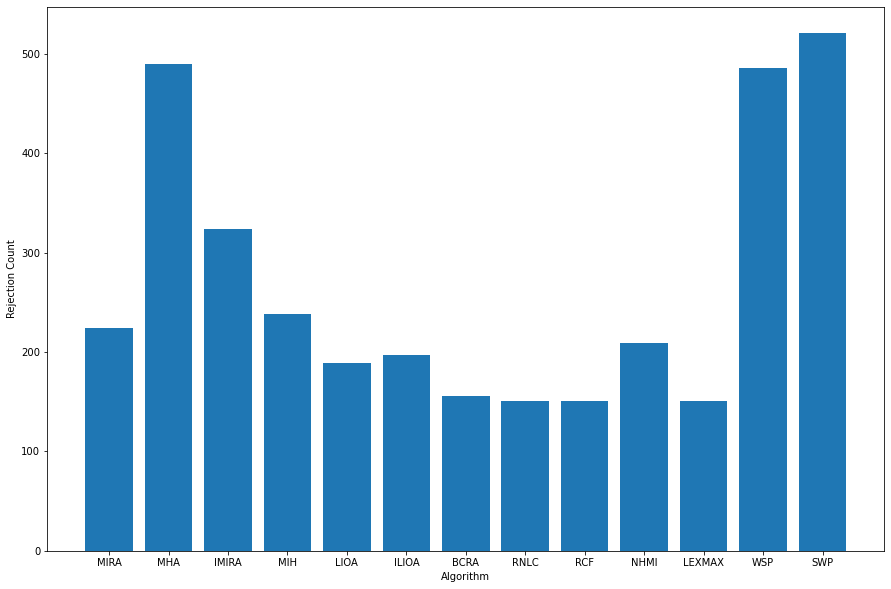

In [62]:
rejection_list={}
for alg in algorithm_list:
    comparison_db[alg]["TOTALREJECTION"]=sum(comparison_db[alg]["REJECTION"].values())
    rejection_list[alg]=comparison_db[alg]["TOTALREJECTION"]
plt.figure(figsize=(15,10))
plt.bar(rejection_list.keys(),rejection_list.values())
plt.xlabel("Algorithm")
plt.ylabel("Rejection Count")

##### PATH LENGTH PLOTTER

Text(0, 0.5, 'PATH LENGTH')

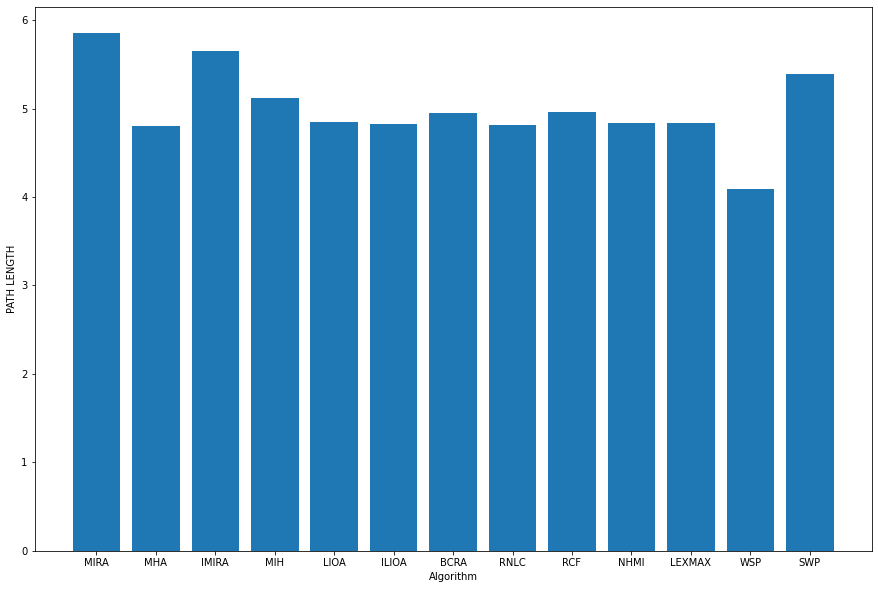

In [65]:
pathlength_list={}
for alg in algorithm_list:
    comparison_db[alg]["TOTALPATHLENGTH"]=sum(comparison_db[alg]["PATHLENGTH"].values())/4
    rejection_list[alg]=comparison_db[alg]["TOTALPATHLENGTH"]
plt.figure(figsize=(15,10))
plt.bar(rejection_list.keys(),rejection_list.values())
plt.xlabel("Algorithm")
plt.ylabel("PATH LENGTH")

##### LINK USAGE PLOTTER

In [98]:
import csv
with open("linkusage.csv","w") as csvf:
    writer=csv.writer(csvf)
    csv_list=["ALGORITHM"]
    for l in comparison_db[alg]["LINKUSAGE"].keys():
        csv_list.append(str(l))
    writer.writerow(csv_list)
    for alg in algorithm_list:
        #print(list(comparison_db[alg]["LINKUSAGE"].values()))
        temp=[alg]
        for v in list(comparison_db[alg]["LINKUSAGE"].values()):
            temp.append(v)
            
        writer.writerow(temp)
    

##### Max Flow Decrease Plotter

Text(0, 0.5, 'Sum of Maxflow Value')

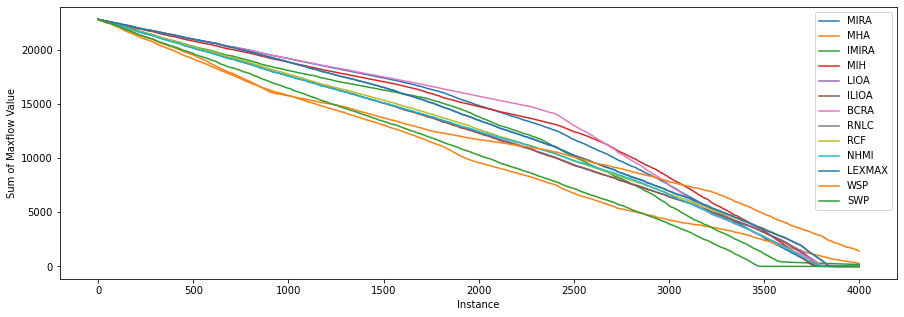

In [133]:
plt.figure(figsize=(15,5))
alg="MIRA"
for alg in algorithm_list:
    comparison_db[alg]["TOTALMAXFLOWDECREASE"]=0
    mf_list=[]
    total_mf_list={}
    for alg in algorithm_list:
        mf_list=[]
        for keys,values in comparison_db[alg]["MAXFLOWDECREASE"].items():
            mf_list.append(values)
        temp=[]
        index=0
        t_val=0
        for i in range(4000):
            for lst in mf_list:
                t_val+=lst[i]
                #print(al,t_val,i)
            temp.append(t_val)
            t_val=0
        total_mf_list[alg]=temp
        
for alg in algorithm_list:
    plt.plot(range(0,4000),total_mf_list[alg])
plt.legend(algorithm_list)
plt.xlabel("Instance")
plt.ylabel("Sum of Maxflow Value")
    
    
        

NameError: name 'plt' is not defined

dict_keys([(1, 2), (1, 3), (1, 4), (2, 5), (2, 3), (2, 11), (3, 6), (3, 4), (3, 7), (4, 9), (4, 8), (5, 12), (6, 11), (6, 7), (6, 10), (7, 10), (7, 9), (8, 9), (9, 10), (9, 15), (10, 11), (10, 13), (10, 14), (11, 12), (11, 13), (12, 13), (13, 14), (14, 15)])

In [152]:
for alg in algorithm_list:
    print(alg,comparison_db[alg]["TOTALREJECTION"])

MIRA 224
MHA 490
IMIRA 324
MIH 238
LIOA 189
ILIOA 197
BCRA 156
RNLC 151
RCF 151
NHMI 209
LEXMAX 151
WSP 486
SWP 521


In [153]:
import random
DEMAND=[]
PAIR=[]
for d in range(10000):
    DEMAND.append(random.randint(1,4))
    PAIR.append(random.randint(0,4))